# Big Data Project: Sentiment Analysis on the Lyrics of Popular Music Artists

## Overview
This project aims to analyze the lyrics of some popular music artists, create sentiment scores for each artist, and develop a game based on these scores. The project is divided into three main parts:

### 1. Data Collection
I used Genius's API and lyricsgenuis to collect lyrics for selected artists, ensuring a comprehensive dataset for analysis.

### 2. Text Analysis
I performed text analysis to extract key metrics and created word clouds to identify prevalent themes in the artists' lyrics.

### 3. Sentiment Analysis
I applied sentiment analysis to gauge the overall positivity and negativity in the lyrics, helping to understand the emotional undertones of the artists' work.

### 4. Comparison with Spotify Valence
I compared the sentiment analysis results with Spotify's valence scores to explore correlations between lyrical sentiment and the emotions conveyed by the music.

### 5. Game Development
Using the sentiment scores, I developed a game where artist characters' speeds are influenced by their lyrical sentiments, providing an interactive way to experience the analysis results.



In [237]:
# Importing necessary libraries
import requests
from bs4 import BeautifulSoup
import lyricsgenius
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import os.path
import os
import csv
import time

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Setting up Genius API access token
client_access_token = "uYYUewikZCOZShFCR9e6EGh3nGRiH-VvRejDnRGvMySzXy1_jBgifnBAuNxfQCog"

# Importing credentials
from credentials import CLIENT_ID, CLIENT_SECRET_ID

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kynajain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kynajain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
# List of 10 song artists
artists = [
    "Taylor Swift",
    "Lana Del Rey",
    "The Weeknd",
    "SZA",
    "Kendrick Lamar",
    "Radiohead",
    "Frank Ocean",
    "Men I Trust",
    "Kanye West",
    "Phoebe Bridgers"
]

In [239]:
# Function to search for song artist id 
def search_artist_id(artist_name):
    url = f"https://api.genius.com/search?q={artist_name}"
    headers = {'Authorization': f'Bearer {client_access_token}'}
    response = requests.get(url, headers=headers, timeout= 10)
    json_response = response.json()
    for hit in json_response['response']['hits']:
        if hit['result']['primary_artist']['name'].lower() == artist_name.lower(): #Searching for an artist's ID based on their name
            return hit['result']['primary_artist']['id']
        else: 
                return None


# Main nested dictionary to store data in the format- {artist: {song: lyrics}}
"""Initially i was going to use a nested dictionary for the data then realsied if i were to increase the number of songs it would be difficult as the data would have to be stored on RAM
better to store on hard drive as csv """
artist_songs = {} 

for artist in artists:
    artist_id = search_artist_id(artist)
    print(artist_id)

1177
15740
2358
41579
1421
604
1985
655044
72
1012909


In [ ]:
# Function to search for songs using artist id and retrieving the lyrics (core data)
def search_artist_songs(artist_name, client_access_token, max_songs=10):
    #Fetch and print song hits for a given artist 
    songs = []
    page = 1 # Used chatgpt 3.5 to add pagination support (previously was fetching unequal number of songs for 2 artists) 
    while len(songs) < max_songs:
        url = f"https://api.genius.com/search?q={artist_name}&page={page}"
        headers = {'Authorization': f'Bearer {client_access_token}'}
        response = requests.get(url, headers=headers)
        json_response = response.json()
        
        # Searching and Fetching song and artist details 
        for hit in json_response['response']['hits']:
            if hit['result']['primary_artist']['name'].lower() == artist_name.lower():
                title = hit['result']['title_with_featured']
                song_url = hit['result']['url']
                song_id = hit['result']['id']
                songs.append({
                    'artist': artist_name,
                    'artist_id': artist_id,
                    'title': title,
                    'song_id': song_id,
                    'song_url': song_url
                })
                if len(songs) >= max_songs:
                    break
        page += 1  # Go to the next page to retrieve more data 

    return songs

# Using the lyricsgenius library to scrape genius lyrics from the song URL
# Documentation: https://lyricsgenius.readthedocs.io/en/master/reference/genius.html

genius = Genius(client_access_token) # Initializing the Genius API client with the provided access token
genius.remove_section_headers = True  # Removing section headers (e.g.Verse 1) from the lyrics

# Function to fetch lyrics using a song url
def fetch_lyrics(song_url):
    lyrics = genius.lyrics(song_url=song_url) 
    if lyrics:
        # Find the position where actual lyrics start after "Lyrics" keyword
        index = lyrics.find("Lyrics")
        if index != -1:  # -1 means not found
            # Extract from the word "Lyrics" onwards
            return lyrics[index + len("Lyrics"):].strip()
        else:
            return lyrics  # Return as is if "Lyrics" keyword not found

all_data = [] # To add to a csv file

for artist in artists:
    hits = search_artist_songs(artist, client_access_token)
    all_data.extend(hits)
    print(f"Artist: {artist}")

    # Making sure the folder for the artist exists
    artist_dir = os.path.join('lyrics')  
    os.makedirs(artist_dir, exist_ok=True) # make a seperate folder for each artist

    for song in hits:
        title = song['title'].replace('/', '-') # Replacing forbidden characters in file names
        song_url = song['song_url']
        song_id = song['song_id']
        print(f"Title: {title}, ID: {song_id}")
        lyrics = fetch_lyrics(song_url)  # Fetching lyrics for each song
        song_filename = os.path.join(artist_dir, title + '.txt') 

        # Save the lyrics to a file within the artist's folder
        with open(song_filename, 'w', encoding='utf-8') as file:
            file.write(lyrics or "No lyrics found.")
            print(f"Lyrics for {title} saved to {song_filename}")

    print("\n")

# Convert list of dictionaries to df
df = pd.DataFrame(all_data)

# Save df to csv
df.to_csv('artist_songs.csv', index=False)

print("Data saved to 'artist_songs.csv'.")


## Sentiment Analysis
Using NLTK's Vader Sentiment Analyzer, I analyzed the lyrics of various artists to quantify how positive, neutral, or negative their lyrics are. The Vader analyzer proved superior in detecting nuanced differences in sentiment intensity, esp in tricky sentences where TextBlob showed limitations. https://www.nltk.org/howto/sentiment.html


Taylor Swift
Checking directory: ./lyrics/Taylor Swift
Accessing file: ./lyrics/Taylor Swift/Fortnight (Ft. Post Malone).txt
Accessing file: ./lyrics/Taylor Swift/All Too Well (10 Minute Version) (Taylor's Version) [Live Acoustic].txt
Accessing file: ./lyrics/Taylor Swift/All Too Well (10 Minute Version) (Taylor's Version) [From The Vault].txt
Accessing file: ./lyrics/Taylor Swift/Lover.txt
Accessing file: ./lyrics/Taylor Swift/Is It Over Now? (Taylor's Version) [From The Vault].txt
Accessing file: ./lyrics/Taylor Swift/The Tortured Poets Department.txt
Accessing file: ./lyrics/Taylor Swift/​exile (Ft. Bon Iver).txt
Accessing file: ./lyrics/Taylor Swift/​the 1.txt
Accessing file: ./lyrics/Taylor Swift/​cardigan.txt
Accessing file: ./lyrics/Taylor Swift/​​thanK you aIMee.txt
Lana Del Rey
Checking directory: ./lyrics/Lana Del Rey
Accessing file: ./lyrics/Lana Del Rey/​hope is a dangerous thing for a woman like me to have - but i have it.txt
Accessing file: ./lyrics/Lana Del Rey/Summertim

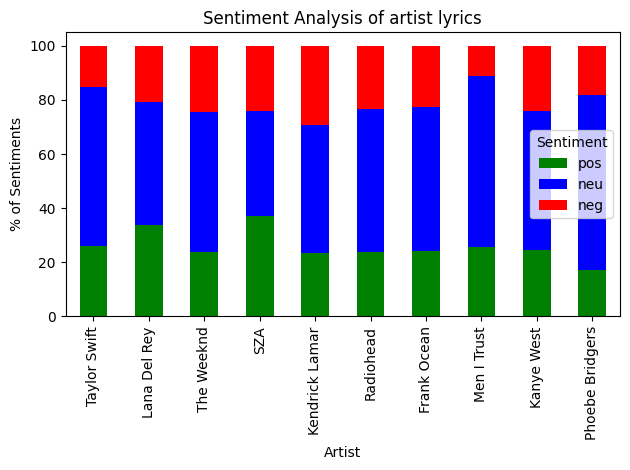

In [243]:
# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Dataframe to store scores
df = pd.DataFrame(columns=['artist', 'pos', 'neu', 'neg', 'compound'])

# Path to lyrics folder
lyrics_root = "./lyrics"

# Analyze lyrics for each artist
for artist in artists:
    num_positive = 0
    num_negative = 0
    num_neutral = 0
    total_compound = 0
    line_count = 0
    print(artist)

    artist_dir = os.path.join(lyrics_root, artist)
    print(f"Checking directory: {artist_dir}")   # Debugging print using Chatgpt 3.5 

    if not os.path.exists(artist_dir):
        print(f"Directory not found for {artist}, skipping.") # Error handling using Chatgpt 3.5 
        continue

    # Iterating over each song file in the artist's folder
    for song_file in os.listdir(artist_dir):
        song_path = os.path.join(artist_dir, song_file)
        print(f"Accessing file: {song_path}")  # Debugging print

        if os.path.isfile(song_path):
            with open(song_path, 'r', encoding='utf-8') as file:
                for line in file:
                    if line.strip():  # Ensure the line has content, used Chatgpt 3.5 for this logic 
                        ss = sid.polarity_scores(line.strip())
                        total_compound += ss['compound']
                        line_count += 1
                        if ss['compound'] >= 0.05:  # Consider positive
                            num_positive += 1
                        elif ss['compound'] <= -0.05:  # Consider negative
                            num_negative += 1
                        else:  # Consider neutral
                            num_neutral += 1

    total = num_positive + num_negative + num_neutral
    if total > 0:
        pos = (num_positive / total) * 100
        neu = (num_neutral / total) * 100
        neg = (num_negative / total) * 100
        avg_compound = total_compound / line_count #getting compound value bygetting sum and normalising it 

        # Append the sentiment percentages to the df using iloc
        df.loc[len(df)] = [artist, pos, neu, neg, avg_compound]

# Saving teh results to a csv file
csv_file_path = 'sentiment_analysis_results_comp.csv'
df.to_csv(csv_file_path, index=False)
print(f"Sentiment scores saved to {csv_file_path}")

# Print results
print(df)

# Plotting
if not df.empty:
    df[['artist', 'pos', 'neu', 'neg']].set_index('artist').plot(kind='bar', stacked=True, color=['green', 'blue', 'red']) # line written with help of chatgpt 3.5 (added compound value in version 2)
    plt.title('Sentiment Analysis of artist lyrics')
    plt.ylabel('% of Sentiments')
    plt.xlabel('Artist')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

## Inferences from Sentiment Scores

The sentiment analysis provided several interesting insights:

- **Positivity**: Artists like SZA and Lana Del Rey, who are known for their evocative and often uplifting lyrics, recorded higher positivity in their sentiment scores. This aligns well with their public personas and musical themes.

- **Negativity**: Contrasting this, Kendrick Lamar and Radiohead, who are recognized for their introspective and sometimes somber lyrical content, showed higher negativity. This distinction is particularly poignant in understanding the different thematic explorations in their music.


## Text Analysis and Wordclouds

This section of the project focuses on analyzing the textual content of the lyrics from various artists. Initially, I compute the total word count for each artist to gauge the verbosity of their lyrics. This is followed by generating word clouds, which visually represent the most frequently used words in their lyrics, offering a graphical depiction of thematic prominence.

## Word Count Analysis
The code calculates and plots the total number of words used by each artist in their song lyrics, providing insights into the extent of lyrical content they produce.



<Figure size 1000x600 with 0 Axes>

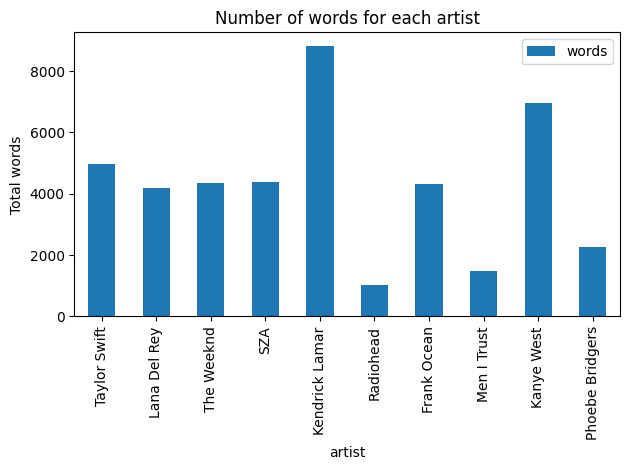

In [242]:
"""Text Analysis and Wordclouds"""

# Adding columns to the df
df = pd.DataFrame(columns=['artist', 'words'])

# Looping through each artist to calculate the word count
for artist in artists:
    artist_dir = os.path.join(lyrics_root, artist)
    total_words = 0
    
    # Iterating over each file in the artist's folder
    for song_file in os.listdir(artist_dir):
        song_path = os.path.join(artist_dir, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            lyrics = file.read()
            word_count = len(lyrics.split())
            total_words += word_count

    # Appending total no of words to the df
    df.loc[len(df)] = [artist, total_words]

# Plotting the results
plt.figure(figsize=(10, 6))
df.plot.bar(x='artist', y='words', title='Number of words for each artist')
plt.ylabel('Total words')
plt.tight_layout()
plt.show()




## Generating Word Clouds
For each artist, a word cloud is generated from their lyrics. These word clouds help visualize the most common words, giving a quick overview of the themes or topics prevalent in their music. The word clouds are saved as PNG files for easy viewing and distribution.

In [ ]:
"""word clouds"""

from wordcloud import WordCloud

# Making sure the wordcloud folder exists
os.makedirs('wordclouds', exist_ok=True) # code from Chatgpt 3.5 for debugging

# Looping through each artist to create a word cloud from their lyrics
for artist in artists:
    artist_dir = os.path.join(lyrics_root, artist) # path to the lyrics file

    # Iterating over each song file in the artist's folder
    for song_file in os.listdir(artist_dir):
        song_path = os.path.join(artist_dir, song_file)

    with open(song_path, 'r', encoding='utf-8') as file: # Reading all words from the lyrics file
        all_words = file.read()

    # Generating and saving the word cloud to a file
    word_cloud = WordCloud(width=1000, height=500).generate(all_words.lower())
    word_cloud_filename = os.path.join('wordclouds'+artist + ".png")
    word_cloud.to_file(word_cloud_filename)
    print(f"Word cloud saved for {artist} to {word_cloud_filename}")

Checking directory: ./lyrics/Taylor Swift
Word cloud saved for Taylor Swift to wordcloudsTaylor Swift.png
Checking directory: ./lyrics/Lana Del Rey
Word cloud saved for Lana Del Rey to wordcloudsLana Del Rey.png
Checking directory: ./lyrics/The Weeknd
Word cloud saved for The Weeknd to wordcloudsThe Weeknd.png
Checking directory: ./lyrics/SZA
Word cloud saved for SZA to wordcloudsSZA.png
Checking directory: ./lyrics/Kendrick Lamar
Word cloud saved for Kendrick Lamar to wordcloudsKendrick Lamar.png
Checking directory: ./lyrics/Radiohead
Word cloud saved for Radiohead to wordcloudsRadiohead.png
Checking directory: ./lyrics/Frank Ocean
Word cloud saved for Frank Ocean to wordcloudsFrank Ocean.png
Checking directory: ./lyrics/Men I Trust
Word cloud saved for Men I Trust to wordcloudsMen I Trust.png
Checking directory: ./lyrics/Kanye West
Word cloud saved for Kanye West to wordcloudsKanye West.png
Checking directory: ./lyrics/Phoebe Bridgers
Word cloud saved for Phoebe Bridgers to wordcloud

In [257]:
# import pandas as pd

# # Load the CSV file containing sentiment results
# df = pd.read_csv('sentiment_analysis_results_comp.csv')

# # Define the old range of compound values and the new range for game speeds
# old_min = -1
# old_max = 1
# new_min = 1
# new_max = 150

# # Normalize the compound values to the new range (1 to 100)
# df['game_speed'] = ((df['compound'] - old_min) / (old_max - old_min) * (new_max - new_min)) + new_min

# # Convert game_speed to integer for use in the game
# df['game_speed'] = df['game_speed']
# # (df['game_speed'] / 5)

# # Create a new DataFrame with artist names and their corresponding game speeds
# new_df = df[['artist', 'game_speed']]

# # Save this DataFrame to a new CSV file
# new_df.to_csv('game_speeds.csv', index=False)

# print("Game speeds based on sentiment analysis have been saved.")


Game speeds based on sentiment analysis have been saved.


## Exponential Transformation for Data Linearization

In this section, I detail my process of applying an exponential transformation to the sentiment scores. This technique is used to enhance the distinctions between scores, making them more useful for gemphasizing subtle differences in sentiment scores.

### Process Overview
- **Transformation**: I applied `np.exp` to the compound sentiment scores to significantly amplify the differences.
- **Normalization and Scaling**: I normalized these transformed scores to a 0-1 range and then scaled them to match a game speed range from 1 to 150.
- **Output**: I converted the final game speeds into integers and saved them to 'game_speeds.csv'. These speeds will dictate the movement of characters in the game based on their associated sentiment scores.


In [258]:
'''Exponential transformation to linearize the data'''
import pandas as pd
import numpy as np  # Import numpy for exponential function

# Load the CSV file containing sentiment results
df = pd.read_csv('sentiment_analysis_results_comp.csv')

# Define the new range for game speeds
new_min = 1
new_max = 150

# Apply an exponential transformation to compound values
# We use np.exp to apply a natural exponential transform
df['transformed_compound'] = np.exp(df['compound']) 

# Normalize the transformed values to the new range (1 to 150)
# First, normalize the transformed compound to 0-1
normalized_compound = (df['transformed_compound'] - df['transformed_compound'].min()) / (df['transformed_compound'].max() - df['transformed_compound'].min()) #Used chatgpt 3.5 to figure out how to linearise the data 

# Then scale it to the new range
df['game_speed'] = normalized_compound * (new_max - new_min) + new_min

# Convert game_speed to integer for use in the game
df['game_speed'] = df['game_speed'].astype(int)

# Create a new df with artist names and their corresponding game speeds
new_df = df[['artist', 'game_speed']]

# Save this df to a csv file
new_df.to_csv('game_speeds.csv', index=False)

print("Game speeds based on sentiment analysis have been saved with exponential transformation.")


Game speeds based on sentiment analysis have been saved with exponential transformation.
